In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import quandl

import cvxportfolio as cp

### Download data 

In [3]:
tickers = ['AMZN', 'GOOGL', 'MCD', 'NKE']
start_date='2016-01-01'
end_date=pd.datetime.today().date()
prices = pd.DataFrame(dict([(ticker, quandl.get('WIKI/'+ticker, 
                                    start_date=start_date, 
                                    end_date=end_date)['Adj. Close'])
                for ticker in tickers]))

returns=prices.pct_change()
returns[["USDOLLAR"]]=quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date)/(250*100)
returns = returns.fillna(method='ffill').iloc[1:]

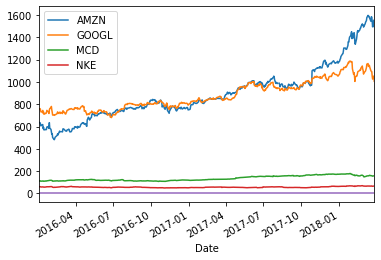

In [4]:
prices.plot()
returns["USDOLLAR"].plot()

In [5]:
returns.rolling(window=250, min_periods=250).cov()

AMZN         GOOGL           MCD           NKE  \
Date                                                                          
2016-01-05 AMZN               NaN           NaN           NaN           NaN   
           GOOGL              NaN           NaN           NaN           NaN   
           MCD                NaN           NaN           NaN           NaN   
           NKE                NaN           NaN           NaN           NaN   
           USDOLLAR           NaN           NaN           NaN           NaN   
...                           ...           ...           ...           ...   
2018-03-27 AMZN      2.360404e-04  1.249706e-04  4.285805e-05  2.134705e-05   
           GOOGL     1.249706e-04  1.677812e-04  4.854822e-05  4.513316e-05   
           MCD       4.285805e-05  4.854822e-05  1.112526e-04  2.353573e-05   
           NKE       2.134705e-05  4.513316e-05  2.353573e-05  2.101542e-04   
           USDOLLAR  4.187351e-09 -1.597689e-08 -1.390047e-08  7.338515e-09   

                         USDOLLAR  
Date                               
2016-01-05 AMZN               NaN  
           GOOGL              NaN  
           MCD                NaN  
           NKE                NaN  
           USDOLLAR           NaN  
...                           ...  
2018-03-27 AMZN      4.187351e-09  
           GOOGL    -1.597689e-08  
           MCD      -1.390047e-08  
           NKE       7.338515e-09  
           USDOLLAR  1.115554e-10  

[2800 rows x 5 columns]

In [6]:
returns.rolling(window=250, min_periods=250).cov().shift(1)

AMZN         GOOGL           MCD           NKE  \
Date                                                                          
2016-01-05 AMZN               NaN           NaN           NaN           NaN   
           GOOGL              NaN           NaN           NaN           NaN   
           MCD                NaN           NaN           NaN           NaN   
           NKE                NaN           NaN           NaN           NaN   
           USDOLLAR           NaN           NaN           NaN           NaN   
...                           ...           ...           ...           ...   
2018-03-27 AMZN      7.418627e-09 -1.182069e-08 -1.342887e-08  6.305083e-09   
           GOOGL     2.360404e-04  1.249706e-04  4.285805e-05  2.134705e-05   
           MCD       1.249706e-04  1.677812e-04  4.854822e-05  4.513316e-05   
           NKE       4.285805e-05  4.854822e-05  1.112526e-04  2.353573e-05   
           USDOLLAR  2.134705e-05  4.513316e-05  2.353573e-05  2.101542e-04   

                         USDOLLAR  
Date                               
2016-01-05 AMZN               NaN  
           GOOGL              NaN  
           MCD                NaN  
           NKE                NaN  
           USDOLLAR           NaN  
...                           ...  
2018-03-27 AMZN      1.103604e-10  
           GOOGL     4.187351e-09  
           MCD      -1.597689e-08  
           NKE      -1.390047e-08  
           USDOLLAR  7.338515e-09  

[2800 rows x 5 columns]

In [7]:
r_hat = returns.rolling(window=250, min_periods=250).mean().shift(1).dropna()
Sigma_hat = returns.rolling(window=250, min_periods=250).cov().shift(1).dropna()

In [8]:
tcost_model=cp.TcostModel(half_spread=10E-4)
hcost_model=cp.HcostModel(borrow_costs=1E-4)

risk_model = cp.FullSigma(Sigma_hat)
gamma_risk, gamma_trade, gamma_hold = 5., 1., 1.
leverage_limit = cp.LeverageLimit(3)

spo_policy = cp.SinglePeriodOpt(return_forecast=r_hat, 
                                costs=[gamma_risk*risk_model, gamma_trade*tcost_model, gamma_hold*hcost_model],
                                constraints=[leverage_limit])

### Compute optimal trades 

In [9]:
current_portfolio=pd.Series(index=r_hat.columns,data=0)
current_portfolio.USDOLLAR=10000

shares_to_trade=spo_policy.get_rounded_trades(current_portfolio, prices, t=pd.datetime.today())
#shares_to_trade=spo_policy.get_rounded_trades(current_portfolio, prices, t=pd.to_datetime("2016-04"))

shares_to_trade

AssertionError: 

#### Export to Excel file 

In [10]:
pd.DataFrame({pd.datetime.today().date().__str__():shares_to_trade}).to_excel('shares_to_trade.xls')